# <font style="color:rgb(50,120,229)"> Learning Rate Schedulers </font>

La tasa de aprendizaje ($\lambda$) es un hiperparámetro que determina qué tan grande debe ser el paso que debemos tomar en cada iteración al actualizar los parámetros del modelo durante el entrenamiento.

$$W_{i+1} = W_{i} - \lambda * \frac{\partial L}{\partial W}$$

Al entrenar un modelo desde cero, generalmente comenzamos con una tasa de aprendizaje más alta, pero a medida que avanza el aprendizaje, reducir la tasa de aprendizaje puede ayudar a mejorar la velocidad de convergencia y a veces incluso resulta en una mayor precisión (pérdida más baja).

En TensorFlow, podemos agregar programadores de tasa de aprendizaje usando el módulo [`tf.keras.optimizers.schedules`](https://keras.io/api/optimizers/learning_rate_schedules/).



En este cuaderno, aprenderemos sobre tres programadores de tasa de aprendizaje diferentes en TensorFlow utilizando los datos de [Rock, Paper, Scissors](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors) de TensorFlow datasets [tfds](https://www.tensorflow.org/datasets/api_docs/python/tfds). Específicamente, echaremos un vistazo a los siguientes programadores de tasa de aprendizaje:

- Decaimiento Constante Escalonado
- Decaimiento Inverso en el Tiempo
- Decaimiento Exponencial


## <font style="color:rgb(50,120,229)"> 1. Descargar y Preprocesar los Datos </font>

In [1]:
label_names = {
    'Rock'     : 0,
    'Paper'    : 1,
    'Scissors' : 2,
}

In [2]:
import tensorflow_datasets as tfds

def get_dataset():
    train_ds = tfds.load('rock_paper_scissors', split=tfds.Split.TRAIN, batch_size=-1)
    test_ds = tfds.load('rock_paper_scissors', split=tfds.Split.TEST, batch_size=-1)

    train_ds =tfds.as_numpy(train_ds)
    test_ds =tfds.as_numpy(test_ds)

    X_train, y_train = train_ds['image'], train_ds['label']
    X_test, y_test = test_ds['image'], test_ds['label']

    return X_train, y_train, X_test, y_test

In [3]:
X_train, y_train, X_test, y_test = get_dataset()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.2DTQ01_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.2DTQ01_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [4]:
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")

print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (2520, 300, 300, 3)
y_train.shape: (2520,)
X_test.shape: (372, 300, 300, 3)
y_test.shape: (372,)


Aplicamos one-hot encoding a las etiquetas

In [5]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

y_train.shape: (2520, 3)
y_test.shape: (372, 3)


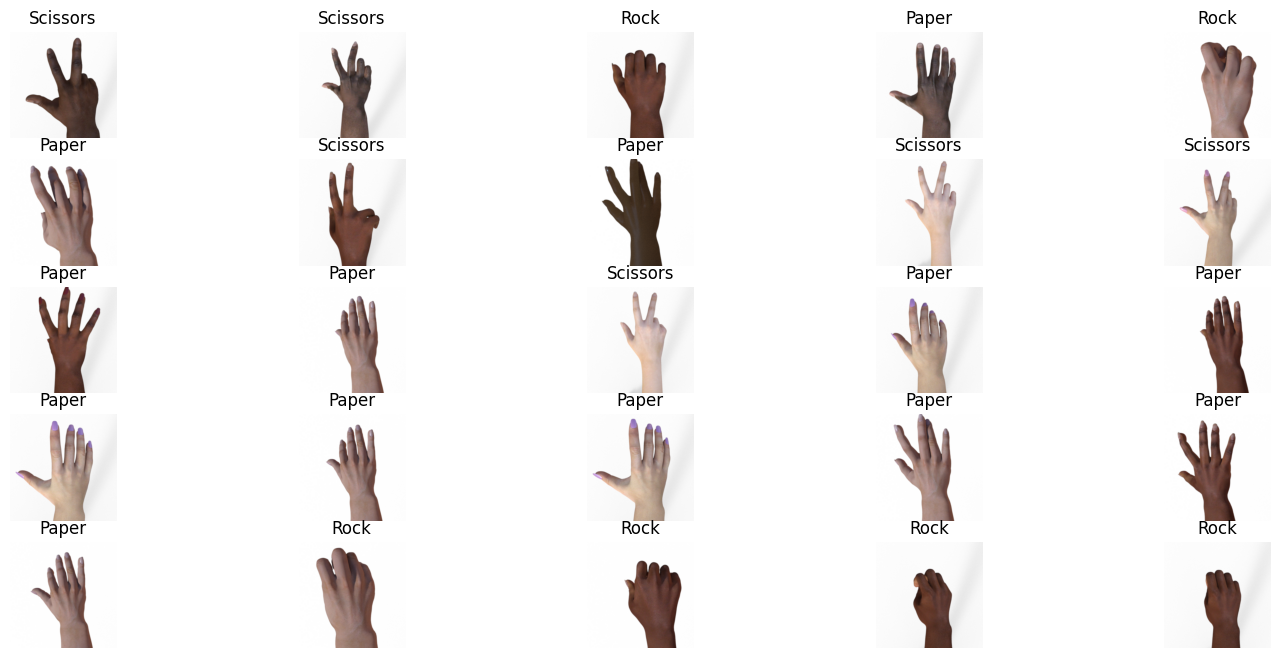

In [6]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18, 8))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.axis('off')

    image = X_train[i]
    label = y_train[i].argmax()

    class_name = list(label_names.keys())[list(label_names.values()).index(label)]

    plt.imshow(image)
    plt.title(class_name)

plt.show()

## <font style="color:rgb(50,120,229)"> 2. Crear el Modelo </font>

In [7]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Rescaling

def LeNet5_model(num_classes, shape):

    inputs = Input(shape=shape)

    x = Rescaling(scale=1./255)(inputs)

    x = Conv2D(6, kernel_size=(5, 5), activation='relu')(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    x = Conv2D(16, kernel_size=(5, 5), activation='relu')(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    x = Flatten()(x)

    x = Dense(120, activation='relu')(x)
    x = Dense(84, activation='relu')(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

## <font style="color:rgb(50,120,229)"> 3. Entrenar el Modelo </font>

In [8]:
from keras.callbacks import EarlyStopping


def train_model(X_train, y_train, X_test, y_test, model, optimizer, epochs=25):

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[early_stopping])

    return history

In [9]:
def plot_loss_accuracy(history):
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Loss evolution')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.title('Accuracy evolution')

    plt.show()

### <font style="color:rgb(50,120,229)"> 3.1 Sin Programador de Tasa de Aprendizaje </font>

En nuestro primer experimento, entrenaremos el modelo sin un programador de tasa de aprendizaje.

Utilizaremos el optimizador Adam con una tasa de aprendizaje de 0.001.

Epoch 1/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.6426 - loss: 2.3211 - val_accuracy: 0.6935 - val_loss: 0.8983
Epoch 2/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 232s 3s/step - accuracy: 0.9962 - loss: 0.0160 - val_accuracy: 0.7446 - val_loss: 0.7727
Epoch 3/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.9992 - loss: 0.0054 - val_accuracy: 0.7177 - val_loss: 1.1078
Epoch 4/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 1.0000 - loss: 9.1267e-04 - val_accuracy: 0.6882 - val_loss: 1.2957
Epoch 5/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.6720 - val_loss: 1.7692
Epoch 6/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 1.0000 - loss: 7.3620e-05 - val_accuracy: 0.6478 - val_loss: 1.9862
Epoch 7/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 233s 3s/step - accuracy: 1.0000 - loss: 6.4920e-05 - val_accuracy: 0.6694 - val_loss: 1.9109


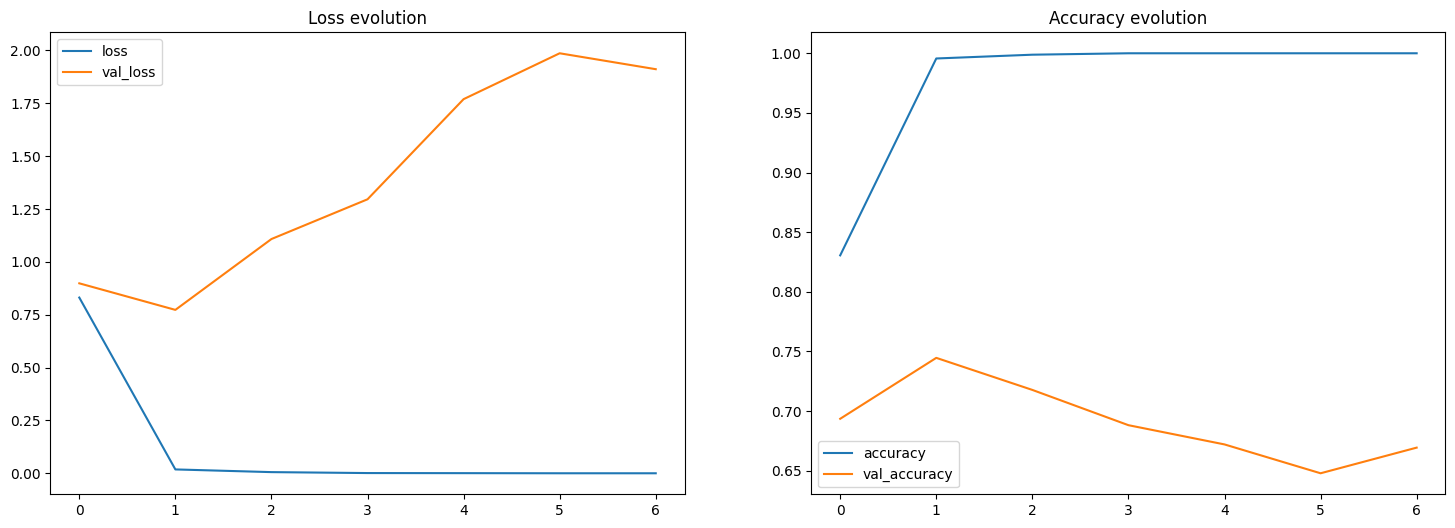

In [10]:
from keras.optimizers import Adam

model = LeNet5_model(num_classes=3, shape=(300, 300, 3))

optimizer = Adam(learning_rate=0.001)

history = train_model(X_train, y_train, X_test, y_test, model, optimizer, epochs=25)

plot_loss_accuracy(history)

### <font style="color:rgb(50,120,229)"> 3.2 Piecewise Constant Decay </font>

`PiecewiseConstantDecay` devuelve un callable de 1 argumento para calcular el decaimiento constante escalonado cuando se le pasa el paso actual del optimizador.

```python
from keras.optimizers.schedules import PiecewiseConstantDecay
scheduler = PiecewiseConstantDecay(
        boundaries,
        values,
        name=None
    )
```

**Parámetros:**

- `boundaries`: Una lista de Tensores o enteros o flotantes con entradas estrictamente crecientes, y con todos los elementos teniendo el mismo tipo que el paso del optimizador.
- `values`: Una lista de Tensores o flotantes o enteros que especifica los valores para los intervalos definidos por los límites. Debería tener un elemento más que los límites, y todos los elementos deberían tener el mismo tipo.
- `name`: Una cadena. Nombre opcional de la operación. Por defecto es 'PiecewiseConstant'.

In [11]:
from keras.optimizers.schedules import PiecewiseConstantDecay

boundaries = [1300, 2600]
values = [0.001, 0.0001, 0.00001]

lr_schedule = PiecewiseConstantDecay(boundaries, values)

Al especificar `boundaries = [1300, 2600]` y `values = [0.001, 0.0001, 0.00001]` estamos diciendo que la tasa de aprendizaje será 0.001 hasta el paso 1300, luego 0.0001 hasta el paso 2600 y finalmente 0.00001 después del paso 2600.

Cada paso de entrenamiento sucede cuando se procesa un lote de datos.

Si tenemos 1000 imágenes en el conjunto de datos y un tamaño de lote de 32, entonces cada epoca tendrá 1000/32 = 31 pasos. Por lo tanto, si queremos que el cambio de tasa de aprendizaje ocurra después de 1300 pasos, entonces necesitamos 1300/31 = 41 epocas.

Epoch 1/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 241s 3s/step - accuracy: 0.6179 - loss: 1.2670 - val_accuracy: 0.7876 - val_loss: 0.5631
Epoch 2/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.9882 - loss: 0.0527 - val_accuracy: 0.7312 - val_loss: 0.9305
Epoch 3/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.7473 - val_loss: 1.0142
Epoch 4/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 1.0000 - loss: 6.4613e-04 - val_accuracy: 0.7366 - val_loss: 1.1510
Epoch 5/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 233s 3s/step - accuracy: 1.0000 - loss: 1.6315e-04 - val_accuracy: 0.7392 - val_loss: 1.2114
Epoch 6/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 1.0000 - loss: 1.2288e-04 - val_accuracy: 0.7258 - val_loss: 1.2737


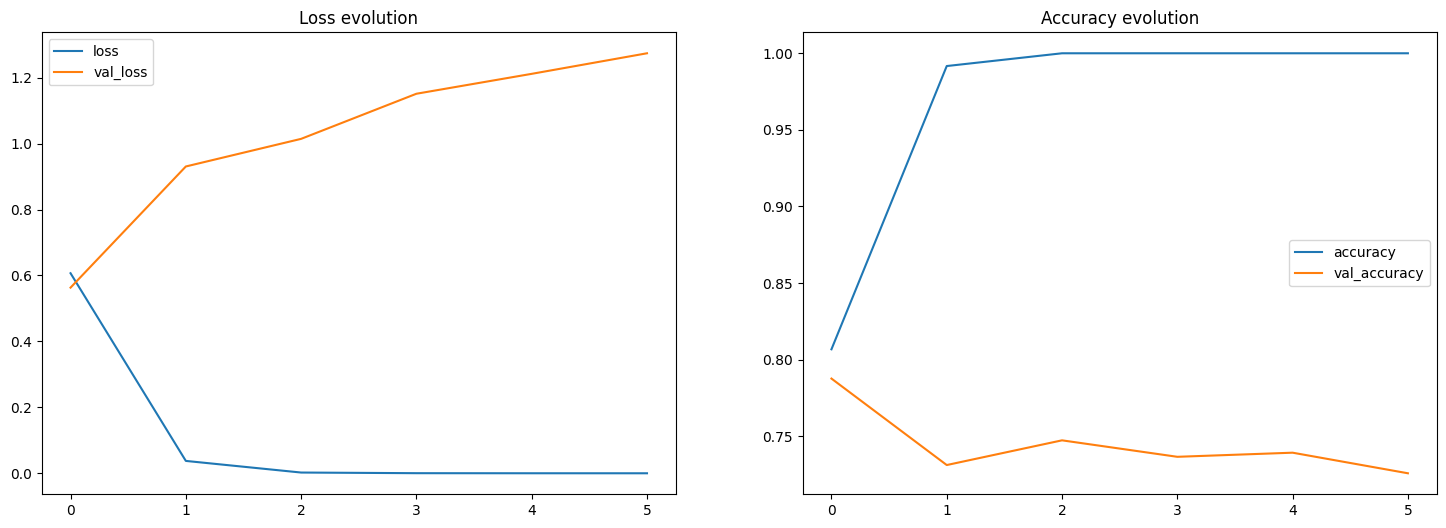

In [12]:
optimizer = Adam(learning_rate=lr_schedule)

model = LeNet5_model(num_classes=3, shape=(300, 300, 3))

history = train_model(X_train, y_train, X_test, y_test, model, optimizer, epochs=25)

plot_loss_accuracy(history)

### <font style="color:rgb(50,120,229)"> 3.3 Inverse Time Decay </font>

Este programador aplica la función de decaimiento inverso a un paso del optimizador, dado una tasa de aprendizaje inicial proporcionada.

$$
\alpha = \frac{\alpha_0}{1+\gamma n}
$$

donde,
$\alpha_0$ = tasa de aprendizaje inicial  
$\gamma$ = tasa de decaimiento  
$n$ = paso / pasos_de_decaimiento

```python
from keras.optimizers.schedules import InverseTimeDecay

scheduler = InverseTimeDecay(
        initial_learning_rate,
        decay_steps,
        decay_rate,
        staircase=False,
        name=None
    )
```

- `initial_learning_rate`: Un Tensor escalar `float32` o `float64` o un número de Python. La tasa de aprendizaje inicial.
- `decay_steps`: Con qué frecuencia aplicar el decaimiento.
- `decay_rate`: Un número de Python. La tasa de decaimiento.
- `staircase`: Si aplicar el decaimiento de manera discreta, en forma de escalera, en lugar de manera continua.
- `name`: Cadena. Nombre opcional de la operación. Por defecto es 'InverseTimeDecay'.


Epoch 1/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.3190 - loss: 7638.5566 - val_accuracy: 0.3333 - val_loss: 1.0988
Epoch 2/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.3273 - loss: 1.0988 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 3/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.3164 - loss: 1.0988 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 4/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.3206 - loss: 1.0987 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 5/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 0.3524 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 6/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.3334 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 7/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 271s 3s/step - accuracy: 0.3389 - loss: 1.0987 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 8/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.3310 - loss: 1.0987 - val_accuracy: 0.3333 

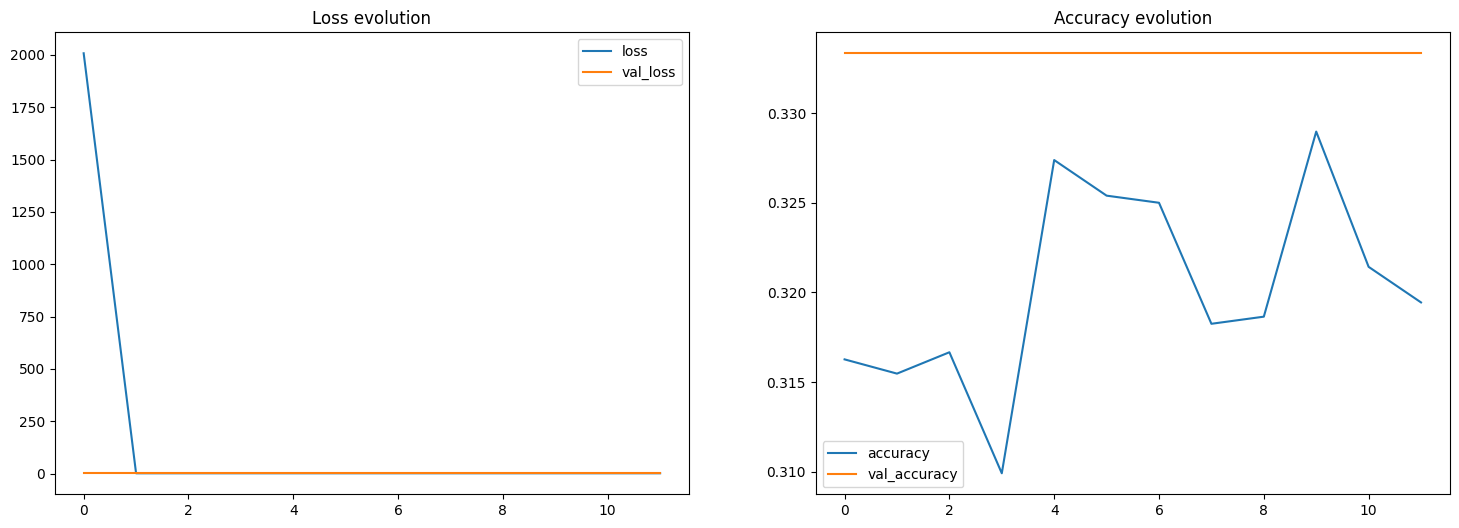

In [13]:
from keras.optimizers.schedules import InverseTimeDecay

initial_learning_rate = 0.1
decay_steps = 1
decay_rate = 0.5

lr_schedule = InverseTimeDecay(initial_learning_rate, decay_steps, decay_rate)

optimizer = Adam(learning_rate=lr_schedule)

model = LeNet5_model(num_classes=3, shape=(300, 300, 3))

history = train_model(X_train, y_train, X_test, y_test, model, optimizer, epochs=25)

plot_loss_accuracy(history)

### <font style="color:rgb(50,120,229)"> 3.4 Exponential Decay </font>

Este programador aplica una función de decaimiento exponencial a un paso del optimizador, dada una tasa de aprendizaje inicial.

$$
\alpha = \alpha_0*\gamma^n
$$

donde,
$\alpha_0$ = tasa de aprendizaje inicial  
$\gamma$ = tasa de decaimiento  
$n$ = pasos / pasos_de_decaimiento


```python
from keras.optimizers.schedules import ExponentialDecay

scheduler = ExponentialDecay(
        initial_learning_rate,
        decay_steps,
        decay_rate,
        staircase=False,
        name=None
    )
```

- `initial_learning_rate`: Un Tensor escalar `float32` o `float64` o un número de Python. La tasa de aprendizaje inicial.
- `decay_steps`: Un Tensor escalar `int32` o `int64` o un número de Python. Debe ser positivo. Consulta el cálculo de decaimiento arriba.
- `decay_rate`: Un Tensor escalar `float32` o `float64` o un número de Python. La tasa de decaimiento.
- `staircase`: Booleano. Si es `True`, decae la tasa de aprendizaje en intervalos discretos.
- `name`: Cadena. Nombre opcional de la operación. Por defecto es 'ExponentialDecay'.


In [ ]:
from keras.optimizers.schedules import ExponentialDecay

initial_learning_rate = 0.001
decay_rate = 0.96
decay_steps = 100

lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate)

optimizer = Adam(learning_rate=lr_schedule)

model = LeNet5_model(num_classes=3, shape=(300, 300, 3))

history = train_model(X_train, y_train, X_test, y_test, model, optimizer, epochs=25)

plot_loss_accuracy(history)

Epoch 1/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 238s 3s/step - accuracy: 0.6303 - loss: 1.2104 - val_accuracy: 0.6237 - val_loss: 1.2414
Epoch 2/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.9971 - loss: 0.0128 - val_accuracy: 0.5726 - val_loss: 1.9004
Epoch 3/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.9960 - loss: 0.0099 - val_accuracy: 0.7446 - val_loss: 1.2165
Epoch 4/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 1.0000 - loss: 5.0193e-04 - val_accuracy: 0.7608 - val_loss: 1.1753
Epoch 5/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 1.0000 - loss: 1.4483e-04 - val_accuracy: 0.7446 - val_loss: 1.3046
Epoch 6/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 1.0000 - loss: 1.3583e-04 - val_accuracy: 0.7500 - val_loss: 1.2810
Epoch 7/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 271s 3s/step - accuracy: 1.0000 - loss: 8.6843e-05 - val_accuracy: 0.7554 - val_loss: 1.2949
Epoch 8/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 1.0000 - loss: 7.5919e-05 - val_

## <font style="color:rgb(50,120,229)"> 4. Comparación de los Programadores de Tasa de Aprendizaje </font>

<center>
    <img src="https://github.com/sofiapapadron/IME_IAA/blob/main/Teoria/2_Clasificacion_imagenes_Keras/3_Conceptos_avanzados_entrenamiento/ejercicios/images/resultados_schedulers.png?raw=1" width=1200>
</center>

## <font style="color:rgb(50,120,229)"> 5. Conclusión </font>

En este cuaderno, exploramos el uso de tres programadores de tasa de aprendizaje diferentes y encontramos que pueden mejorar drásticamente la velocidad de convergencia del modelo.

Como suele ser el caso en el aprendizaje profundo, a menudo se requiere y se recomienda la experimentación para confirmar qué configuraciones funcionan mejor para tu problema particular.

Seleccionar un optimizador y un programador de tasa de aprendizaje apropiados puede marcar una gran diferencia en la cantidad de tiempo requerido para entrenar tu modelo y a veces también puede llevar a una mayor precisión.
